Source: https://github.com/clcarwin/examples/tree/master/fast_neural_style

In [1]:
import argparse
import os
import math
from datetime import datetime

import numpy as np
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.serialization import load_lua
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
# Training settings
parser = {
    'epochs': 2,
    'lr': 0.001,
    'no_cuda': False,
    'dataset': '../../dataset',
    'style_image': 'images/starry_night.jpg',
    'prefix': 'starry_night',
    'batch_size': 1,
    'checkpoint': 0,
    'image_size': 256,
    'style_size': 256,
    'lambda_feat': 1.0,
    'lambda_style': 5.0
}
args = argparse.Namespace(**parser)
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [4]:
class VGGFeature(nn.Module):
    def __init__(self):
        super(VGGFeature, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        h = F.relu(self.conv1_1(x))
        h = F.relu(self.conv1_2(h))
        f1 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h))
        h = F.relu(self.conv2_2(h))
        f2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h))
        h = F.relu(self.conv3_2(h))
        h = F.relu(self.conv3_3(h))
        f3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h))
        h = F.relu(self.conv4_2(h))
        h = F.relu(self.conv4_3(h))
        f4 = h

        # [relu1_2,relu2_2,relu3_3,relu4_3]
        return [f1, f2, f3, f4]

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, num):
        super(ResidualBlock, self).__init__()
        self.c1 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.b1 = nn.BatchNorm2d(num)
        self.b2 = nn.BatchNorm2d(num)

    def forward(self, x):
        h = F.relu(self.b1(self.c1(x)))
        h = self.b2(self.c2(h))
        return h + x

In [6]:
class FastStyleNet(nn.Module):
    def __init__(self):
        super(FastStyleNet, self).__init__()
        self.c1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4)
        self.c2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.c3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.r1 = ResidualBlock(128)
        self.r2 = ResidualBlock(128)
        self.r3 = ResidualBlock(128)
        self.r4 = ResidualBlock(128)
        self.r5 = ResidualBlock(128)
        self.d1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2,
                                     padding=1)
        self.d2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,
                                     padding=1)
        self.d3 = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4)
        self.b1 = nn.BatchNorm2d(32)
        self.b2 = nn.BatchNorm2d(64)
        self.b3 = nn.BatchNorm2d(128)
        self.b4 = nn.BatchNorm2d(64)
        self.b5 = nn.BatchNorm2d(32)

    def forward(self, x):
        h = F.relu(self.b1(self.c1(x)))
        h = F.relu(self.b2(self.c2(h)))
        h = F.relu(self.b3(self.c3(h)))
        h = self.r1(h)
        h = self.r2(h)
        h = self.r3(h)
        h = self.r4(h)
        h = self.r5(h)
        h = F.relu(self.b4(self.d1(h)))
        h = F.relu(self.b5(self.d2(h)))
        y = self.d3(h)
        return y

In [7]:
def download_convert_vgg16_model():
    if not os.path.exists('vgg16feature.pth'):
        if not os.path.exists('vgg16.t7'):
            os.system('wget http://cs.stanford.edu/people/jcjohns/'
                      'fast-neural-style/models/vgg16.t7')
        vgglua = load_lua('vgg16.t7')
        vgg = VGGFeature()
        for (src, dst) in zip(vgglua.parameters()[0], vgg.parameters()):
            dst.data.copy_(src)
        torch.save(vgg.state_dict(), 'vgg16feature.pth')
        
download_convert_vgg16_model()

In [8]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


# batch: Bx3xHxW BGR [0,255] Variable
def vgg_preprocessing(batch):
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size())
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    batch -= Variable(mean)


def save_model(model, filename):
    state = model.state_dict()
    for key in state:
        state[key] = state[key].clone().cpu()
    torch.save(state, filename)


# tensor: RGB CxHxW [0,255]
def tensor_save_rgbimage(tensor, filename):
    img = tensor.clone().cpu().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)


def tensor_save_bgrimage(tensor, filename):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename)


# result: RGB CxHxW [0,255] torch.FloatTensor
def tensor_load_rgbimage(filename, size=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img


# batch: Bx3xHxW
def batch_rgb_to_bgr(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch


def batch_bgr_to_rgb(batch):
    return batch_rgb_to_bgr(batch)

### train

In [9]:
transform = transforms.Compose([transforms.Scale(args.image_size),
                               transforms.CenterCrop(args.image_size),
                               transforms.ToTensor(),
                               transforms.Lambda(lambda x: x.mul(255))])
train = datasets.ImageFolder(args.dataset, transform)
train_loader = DataLoader(train, batch_size=args.batch_size, num_workers=4)
n_iter = len(train_loader)

model = FastStyleNet()
vgg = VGGFeature()
vgg.load_state_dict(torch.load('vgg16feature.pth'))
optimizer = optim.Adam(model.parameters(), lr=args.lr)
if args.cuda:
    model.cuda()
    vgg.cuda()

style = tensor_load_rgbimage(args.style_image, args.style_size)
style = style.repeat(args.batch_size, 1, 1, 1)
style = batch_rgb_to_bgr(style)

if args.cuda:
    style = style.cuda()
style_var = Variable(style, volatile=True)
vgg_preprocessing(style_var)
feature_s = vgg(style_var)
gram_s = [gram_matrix(y) for y in feature_s]

it = 0
loss_fn = torch.nn.MSELoss()
model.train()
for epoch in range(args.epochs):
    for batch in train_loader:
        optimizer.zero_grad()

        # batch[0] is RGB [0,1] BxCxHxW
        # data is BGR [0,255] BxCxHxW
        # y is BGR [0,255] BxCxHxW
        data = batch[0].clone()
        data = batch_rgb_to_bgr(data)
        if args.cuda:
            data = data.cuda()

        x = Variable(data.clone())
        y = model(x)
        vgg_preprocessing(y)
        feature_hat = vgg(y)

        xc = Variable(data.clone(), volatile=True)
        vgg_preprocessing(xc)
        feature = vgg(xc)

        feature_v = Variable(feature[1].data, requires_grad=False)
        L = args.lambda_feat * loss_fn(feature_hat[1], feature_v)
        for m in range(0, len(feature_hat)):
            gram_v = Variable(gram_s[m].data, requires_grad=False)
            L += args.lambda_style * loss_fn(gram_matrix(feature_hat[m]),
                                             gram_v)
        L.backward()
        optimizer.step()

        dt = datetime.now().strftime('%H:%M:%S')
        if it % 10000 == 0:
            print('{} epoch {} batch {}/{}    loss is {}'.format(dt, epoch,
                                                                 it, n_iter,
                                                                 L.data[0]))

        if args.checkpoint > 0 and 0 == it % args.checkpoint:
            save_model(model, '{}_{}_{}.pth'.format(args.prefix, epoch, it))
        it = it + 1
    save_model(model, '{}_{}.pth'.format(args.prefix, epoch))
save_model(model, '{}.pth'.format(args.prefix))

02:29:50 epoch 0 batch 0/82783    loss is 7553882.5
02:50:59 epoch 0 batch 10000/82783    loss is 208410.640625
03:12:09 epoch 0 batch 20000/82783    loss is 182067.0625
03:33:17 epoch 0 batch 30000/82783    loss is 161800.984375
03:54:24 epoch 0 batch 40000/82783    loss is 136857.09375
04:15:31 epoch 0 batch 50000/82783    loss is 134177.703125
04:36:38 epoch 0 batch 60000/82783    loss is 155919.140625
04:57:45 epoch 0 batch 70000/82783    loss is 175589.140625
05:18:52 epoch 0 batch 80000/82783    loss is 176436.15625
05:40:00 epoch 1 batch 90000/82783    loss is 168492.328125
06:01:07 epoch 1 batch 100000/82783    loss is 189237.109375
06:22:14 epoch 1 batch 110000/82783    loss is 153670.15625
06:43:22 epoch 1 batch 120000/82783    loss is 157961.203125
07:04:29 epoch 1 batch 130000/82783    loss is 164432.1875
07:25:36 epoch 1 batch 140000/82783    loss is 168445.484375
07:46:43 epoch 1 batch 150000/82783    loss is 176070.265625
08:07:50 epoch 1 batch 160000/82783    loss is 11

In [24]:
del model

### generate

In [26]:
args.model = 'starry_night.pth'
args.input = 'images/chicago.jpg'
args.output = 'images/output_starry_night.jpg'
args.cuda = False

In [25]:
model = FastStyleNet()
model.load_state_dict(torch.load(args.model))

In [27]:
# load image
img = Image.open(args.input)
img = np.array(img)  # PIL->numpy
img = np.array(img[..., ::-1])  # RGB->BGR
img = img.transpose(2, 0, 1)  # HWC->CHW
img = img.reshape((1, ) + img.shape)  # CHW->BCHW
img = torch.from_numpy(img).float()
img = Variable(img, volatile=True)
if args.cuda:
    model.cuda()
    img = img.cuda()

In [28]:
model.eval()

FastStyleNet (
  (c1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (c2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (r1): ResidualBlock (
    (c1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (b2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  )
  (r2): ResidualBlock (
    (c1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (b2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  )
  (r3): ResidualBlock (
    (c1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel

In [29]:
%%time
output = model(img)
output = output.data.cpu().clamp(0, 255).byte().numpy()
output = output[0].transpose((1, 2, 0))
output = output[..., ::-1]

CPU times: user 21.7 s, sys: 2.06 s, total: 23.7 s
Wall time: 7.39 s


In [30]:
# save output
output = Image.fromarray(output)
output.save(args.output)

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

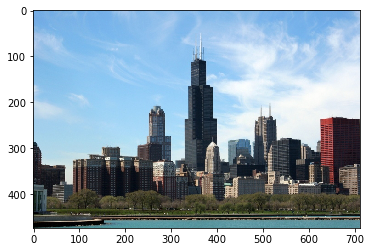

In [32]:
plt.imshow(Image.open(args.input))

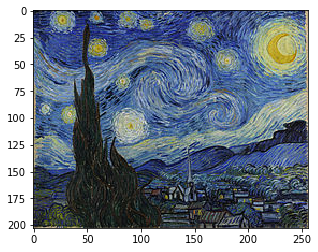

In [33]:
plt.imshow(Image.open(args.style_image))

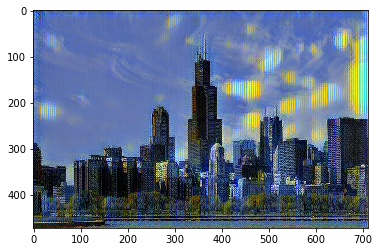

In [34]:
plt.imshow(Image.open(args.output), aspect="auto")